# Import libs

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix

# Read data

In [2]:
df_train = pd.read_csv('data/mnist_train.csv', header=None)
df_test = pd.read_csv('data/mnist_test.csv', header=None)

# Data processing and encoding

In [3]:
X_train = df_train.drop(0, axis=1).to_numpy()
y_train = df_train[0]
X_test = df_test.drop(0, axis=1).to_numpy()
y_test = df_test[0]

del df_train
del df_test

In [4]:
encoder = OneHotEncoder()

In [5]:
X_train = tf.convert_to_tensor(np.array(X_train.tolist()).reshape(-1, 28, 28, 1)/255)
y_train = tf.convert_to_tensor(encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray())
X_test = tf.convert_to_tensor(np.array(X_test.tolist()).reshape(-1, 28, 28, 1)/255)
y_test = tf.convert_to_tensor(encoder.fit_transform(y_test.to_numpy().reshape(-1, 1)).toarray())

# CNN model

In [6]:
cnn_model = tf.keras.Sequential(
    [tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
     tf.keras.layers.MaxPooling2D((2, 2)),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(100, activation=tf.nn.relu),
     tf.keras.layers.Dense(10, activation=tf.nn.softmax)]
)
cnn_model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy', 'AUC'])

In [7]:
with tf.device('GPU'):
    cnn_model.fit(X_train, y_train, epochs=20, batch_size=128)

Epoch 1/20
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
469/469 [==============================] - 5s 11ms/step - loss: 0.0407 - accuracy: 0.9304 - auc: 0.9951
Epoch 2/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0139 - accuracy: 0.9766 - auc: 0.9990
Epoch 3/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0094 - accuracy: 0.9841 - auc: 0.9993
Epoch 4/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0072 - accuracy: 0.9881 - auc: 0.9996
Epoch 5/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0056 - accuracy: 0.9910 - auc: 0.9997
Epoch 6/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0046 - accuracy: 0.9926 - auc: 0.9997
Epoch 7/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0035 - accuracy: 0.9947 - auc: 0.9998
Epoch 8/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0027 - accuracy: 0.9958 - auc: 0.9999

In [8]:
cnn_model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0093 - accuracy: 0.9871 - auc: 0.9987


[0.009309209883213043, 0.9871000051498413, 0.9986974000930786]

# Generate batches of tensor image data augmentation. 

In [9]:
datagen  = image.ImageDataGenerator(rotation_range=[0, 40], 
                                    width_shift_range=(0.01, 1),
                                    height_shift_range=(0.01, 1),
                                    shear_range=(0.01, 1),
                                    zoom_range=(0.01, 1),
                                    horizontal_flip=False)
flow = datagen.flow(X_train, y_train, batch_size=512)

# Make CNN model deeper

In [16]:
cnn_model2 = tf.keras.Sequential(
    [tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
     tf.keras.layers.MaxPooling2D((2, 2)),
     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
     tf.keras.layers.MaxPooling2D((2, 2)),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(512, activation=tf.nn.relu),
     tf.keras.layers.Dense(100, activation=tf.nn.relu),
     tf.keras.layers.Dense(10, activation=tf.nn.softmax)]
)
cnn_model2.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.CategoricalCrossentropy(), 
              metrics=['accuracy', 'AUC'])

In [17]:
%%time
cnn_model2.fit(np.vstack((X_train, flow.x)), np.vstack((y_train, flow.y)), epochs=20, batch_size=512)

Epoch 1/20
235/235 [==============================] - 14s 59ms/step - loss: 0.2095 - accuracy: 0.9389 - auc: 0.9966
Epoch 2/20
235/235 [==============================] - 16s 66ms/step - loss: 0.0400 - accuracy: 0.9878 - auc: 0.9995
Epoch 3/20
235/235 [==============================] - 18s 76ms/step - loss: 0.0243 - accuracy: 0.9926 - auc: 0.9997
Epoch 4/20
235/235 [==============================] - 19s 79ms/step - loss: 0.0155 - accuracy: 0.9952 - auc: 0.9999
Epoch 5/20
235/235 [==============================] - 18s 78ms/step - loss: 0.0114 - accuracy: 0.9965 - auc: 0.9999
Epoch 6/20
235/235 [==============================] - 19s 83ms/step - loss: 0.0082 - accuracy: 0.9972 - auc: 0.9999
Epoch 7/20
235/235 [==============================] - 20s 83ms/step - loss: 0.0061 - accuracy: 0.9980 - auc: 0.9999
Epoch 8/20
235/235 [==============================] - 19s 83ms/step - loss: 0.0061 - accuracy: 0.9980 - auc: 0.9999
Epoch 9/20
235/235 [==============================] - 20s 85ms/step - lo

In [18]:
# cnn_model2.evaluate(flow.x, flow.y)
cnn_model2.evaluate(X_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0374 - accuracy: 0.9932 - auc: 0.9985


[0.037411317229270935, 0.9932000041007996, 0.9985073208808899]

# Accuracy

In [19]:
acc = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(cnn_model2.predict(X_test), axis=1), labels=np.arange(10))

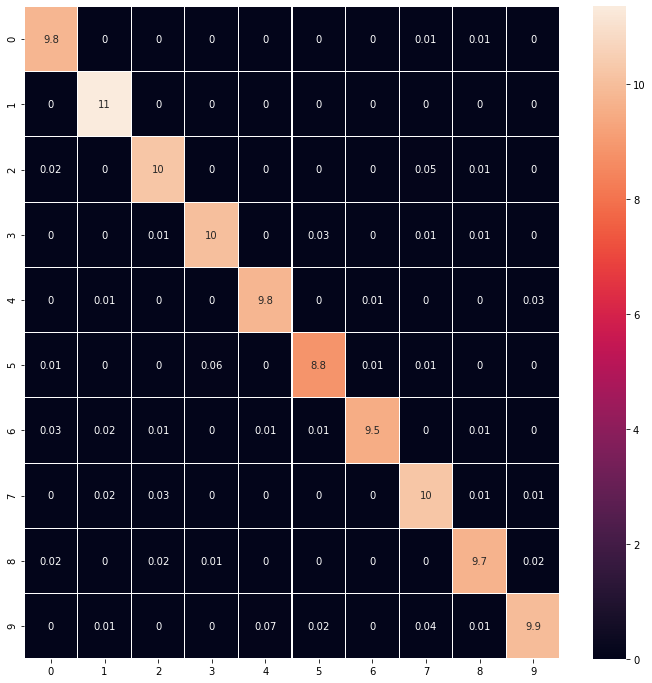

In [20]:
plt.figure(figsize=(12, 12))
sns.heatmap(acc/len(y_test) * 100, annot=True, linewidths=0.1)

# Visualize model

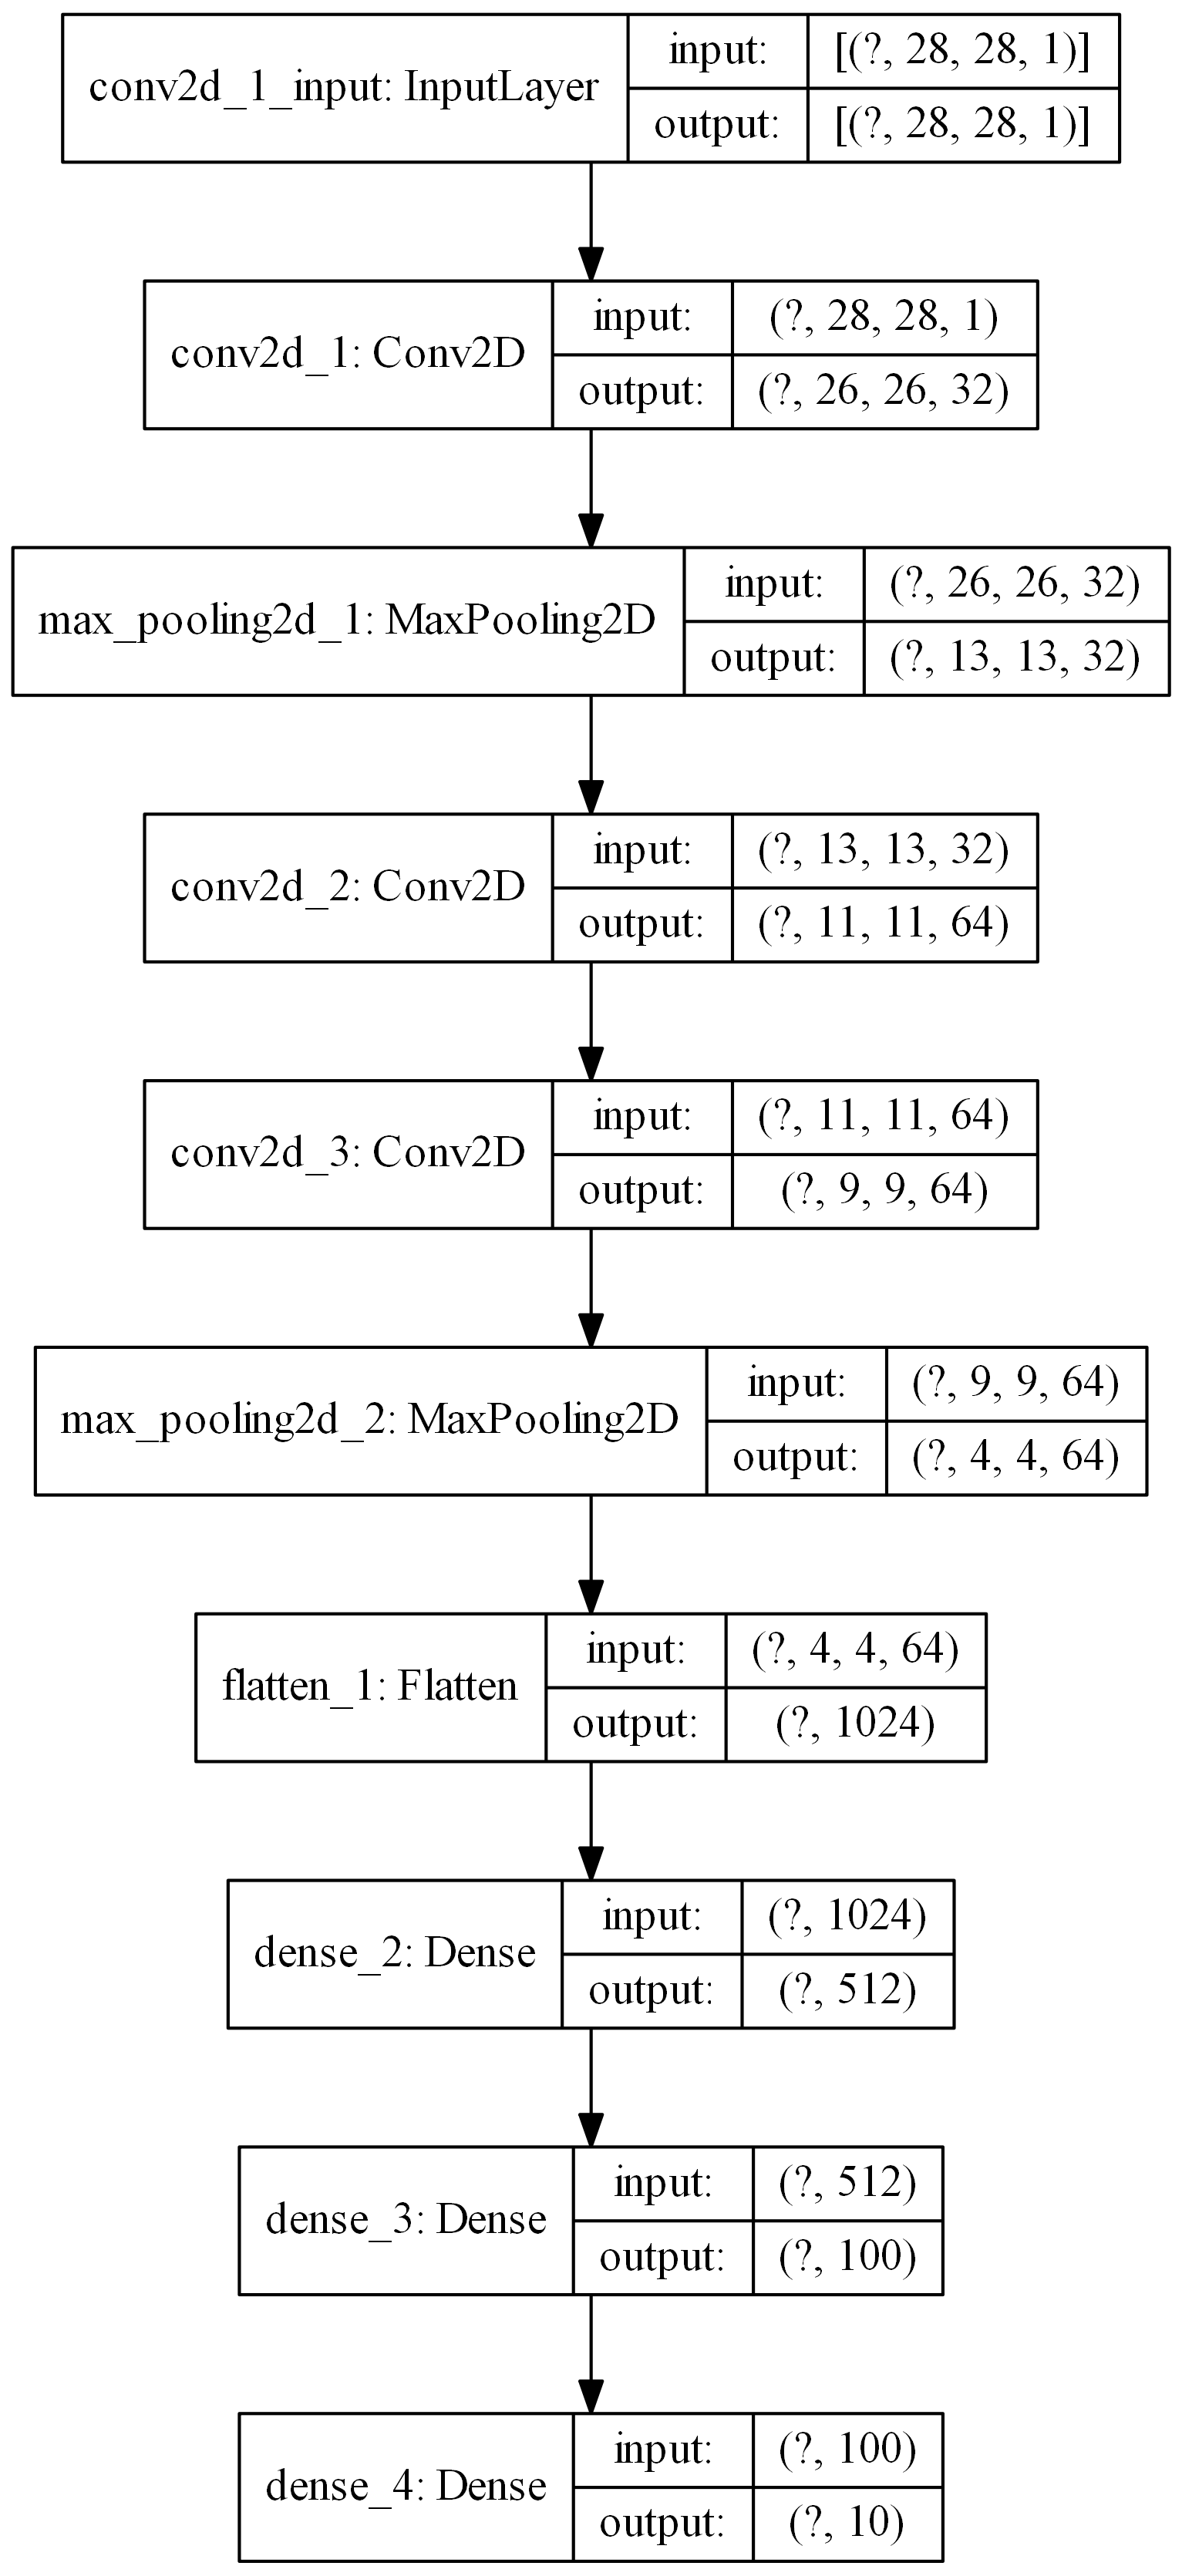

In [41]:
plot_model(cnn_model2, show_shapes=True, expand_nested=True, dpi=300, to_file="img/cnn_model.png")

# Saving model

In [209]:
cnn_model2.save("cnn_model")

INFO:tensorflow:Assets written to: cnn_modal\assets


Saving model in lite format

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("cnn_model")
tflite_model = converter.convert()
open("cnn_model_android.tflite", "wb").write(tflite_model)